In [ ]:
import pandas as pd


In [ ]:
text_df = pd.read_csv('IEMOCAP_TEXT/preprocessed_transcription_text.csv')

In [ ]:
text_df.head()

,filename,text,emotion,processed_text
0,Ses01F_impro01_F000,Excuse me.,neu,excuse me .
1,Ses01F_impro01_M000,Do you have your forms?,fru,do you have your forms ?
2,Ses01F_impro01_F001,Yeah.,neu,yeah .
3,Ses01F_impro01_M001,Let me see them.,fru,let me see them .
4,Ses01F_impro01_F002,Is there a problem?,neu,is there a problem ?


In [ ]:
text_df = text_df.drop(["filename", "processed_text"], axis=1)

In [ ]:
text_df.head()

,text,emotion
0,Excuse me.,neu
1,Do you have your forms?,fru
2,Yeah.,neu
3,Let me see them.,fru
4,Is there a problem?,neu


In [ ]:
text_df = text_df[text_df.emotion != "xxx"]
text_df = text_df[text_df.emotion != "fru"]
text_df = text_df[text_df.emotion != "sur"]
text_df = text_df[text_df.emotion != "exc"]
text_df = text_df[text_df.emotion != "oth"]
text_df = text_df[text_df.emotion != "fea"]
text_df = text_df[text_df.emotion != "dis"]
text_df.head()

,text,emotion
0,Excuse me.,neu
2,Yeah.,neu
4,Is there a problem?,neu
9,Well what's the problem? Let me change it.,neu
23,That's out of control.,ang


NameError: name 'plt' is not defined

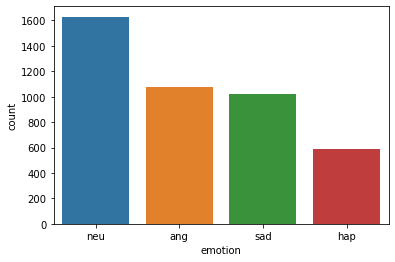

In [ ]:
import seaborn as sns
sns.countplot(x="emotion", data=text_df)
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
text_df['label'] = LE.fit_transform(text_df['emotion'])
text_df.head()

,text,emotion,label
0,Excuse me.,neu,2
2,Yeah.,neu,2
4,Is there a problem?,neu,2
9,Well what's the problem? Let me change it.,neu,2
23,That's out of control.,ang,0


In [ ]:
!pip install transformers 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import numpy as np

msk = np.random.rand(len(text_df)) < 0.8
df_train = text_df[msk]
df_val = text_df[~msk]

In [ ]:
len(df_train)

3492

In [ ]:
len(df_val)

824

In [ ]:
tokenized_train = tokenizer(df_train["text"].values.tolist(), padding = True, truncation = True, return_tensors="pt")
tokenized_val = tokenizer(df_val["text"].values.tolist() , padding = True, truncation = True,  return_tensors="pt")

print(tokenized_train.keys())

#move on device (GPU)
tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

dict_keys(['input_ids', 'attention_mask'])


C:\Users\admin\AppData\Local\Temp\ipykernel_16100\251019150.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
C:\Users\admin\AppData\Local\Temp\ipykernel_16100\251019150.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


In [ ]:
with torch.no_grad():
  hidden_train = model(**tokenized_train) 
  hidden_val = model(**tokenized_val)

cls_train = hidden_train.last_hidden_state[:,0,:]
cls_val = hidden_val.last_hidden_state[:,0,:]

In [ ]:
x_train = cls_train.to("cpu")
y_train = df_train["label"]

x_val = cls_val.to("cpu")
y_val = df_val["label"]

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train,y_train)
rf.score(x_val,y_val) 

torch.Size([3492, 768]) (3492,) torch.Size([824, 768]) (824,)


0.6310679611650486

In [ ]:
def evaluate_model(model):

        
        accuracy = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')

        print(np.mean(accuracy))

In [ ]:
from sklearn.model_selection import cross_val_score

evaluate_model(rf)

0.6142532721735103


In [ ]:
y_pred = rf.predict(x_val)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


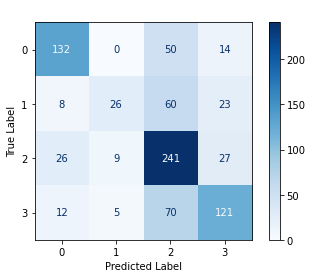

array([[132,   0,  50,  14],
       [  8,  26,  60,  23],
       [ 26,   9, 241,  27],
       [ 12,   5,  70, 121]], dtype=int64)

In [ ]:
from sklearn.metrics import plot_confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn import metrics

color = 'white'
matrix = plot_confusion_matrix(rf, x_val, y_val, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.show()
confusion_matrix = metrics.confusion_matrix(y_val, y_pred)
confusion_matrix

In [ ]:
report = classification_report(y_val, y_pred,output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report

,precision,recall,f1-score,support
0,0.741573,0.673469,0.705882,196.000000
1,0.650000,0.222222,0.331210,117.000000
2,0.572447,0.795380,0.665746,303.000000
3,0.654054,0.581731,0.615776,208.000000
accuracy,0.631068,0.631068,0.631068,0.631068
macro avg,0.654518,0.568200,0.579654,824.000000
weighted avg,0.644287,0.631068,0.615178,824.000000


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.647866 using {'max_features': 'sqrt', 'n_estimators': 1000}
0.571205 (0.022770) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.639178 (0.023178) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.647866 (0.023781) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.563867 (0.020658) with: {'max_features': 'log2', 'n_estimators': 10}
0.632400 (0.024491) with: {'max_features': 'log2', 'n_estimators': 100}
0.638701 (0.023849) with: {'max_features': 'log2', 'n_estimators': 1000}


In [ ]:
rf_final = RandomForestClassifier(n_estimators = 1000,   
                                 max_features = 'sqrt',
                                 random_state = 42)

In [ ]:
rf_final.fit(x_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=1000, random_state=42)

In [ ]:
evaluate_model(rf_final)

0.6271357772667463


0.9607674684994273
0.6614077669902912


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


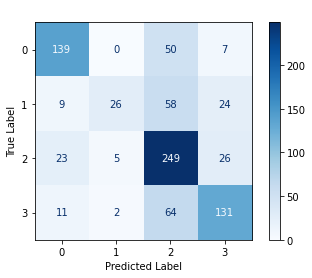

array([[139,   0,  50,   7],
       [  9,  26,  58,  24],
       [ 23,   5, 249,  26],
       [ 11,   2,  64, 131]], dtype=int64)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
 
# performing predictions on the test dataset
y_pred = rf_final.predict(x_val)
print(rf_final.score(x_train,y_train))
print(rf_final.score(x_val,y_val))
color = 'white'
matrix = plot_confusion_matrix(rf_final, x_val, y_val, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.show()
confusion_matrix = metrics.confusion_matrix(y_val, y_pred)
confusion_matrix

In [ ]:
report = classification_report(y_val, y_pred,output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report

,precision,recall,f1-score,support
0,0.763736,0.709184,0.735450,196.000000
1,0.787879,0.222222,0.346667,117.000000
2,0.591449,0.821782,0.687845,303.000000
3,0.696809,0.629808,0.661616,208.000000
accuracy,0.661408,0.661408,0.661408,0.661408
macro avg,0.709968,0.595749,0.607894,824.000000
weighted avg,0.686917,0.661408,0.644104,824.000000
